# Load DATA

In [1]:
import numpy as np
import scipy.io
import pandas as pd

m1_imported = scipy.io.loadmat('/home/klab/Public/Stevenson_50ms.mat')
data = pd.DataFrame()
data['time'] =  m1_imported['time'][:,0]
data['handPos_x'] =  m1_imported['handPos'][:,0]
data['handPos_y'] =  m1_imported['handPos'][:,1]
data['handVel_x'] =  m1_imported['handVel'][:,0]
data['handVel_y'] =  m1_imported['handVel'][:,1]

X = m1_imported['spikes']
Y = m1_imported['handVel']

testSamples  = range(0,1554)
trainSamples = range(1554, Y.shape[0])   

X_test = X[testSamples, :]
Y_test = Y[testSamples, :]
# print(X_test.shape,Y_test.shape)
X_train = X[trainSamples, :]
Y_train = Y[trainSamples, :]
# print(X_train.shape,Y_train.shape)


# Run Neural Networks and average outputs

In [2]:
from copy import copy, deepcopy
from RE_PartialRecData2 import RE_PartialRecData2
from sklearn import preprocessing, linear_model
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import EarlyStopping
import time
from sklearn.metrics import coverage_error
from fancyimpute import SoftImpute
from keras import regularizers


# how many recordings?
nRecordings = 10
# how many iterations
nIterations = 5

# how many neurons from the firs hidden layer?
subnetSize = [2**x for x in range(8)]
subnetSize.append(172)
nSubnetSize = len(subnetSize)
# how many samples per recording?
nSamples = np.divide(int(X_train.shape[0]/nRecordings),subnetSize)*100
nOutNeurons = 2
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])    
    
for ss in range(len(subnetSize)):
    nLayerNeurons = subnetSize[ss]
    print(subnetSize[ss]) 

    for it in range(nIterations):
        start = time.time()         
        # subsample
        X_subsample, Y_subsample = RE_PartialRecData2(X_train, Y_train, nLayerNeurons, nRecordings, nSamples[ss])

        # impute X_subsample with mean value, apply imputation to test set
        imp = preprocessing.Imputer(missing_values='NaN', strategy='mean')
        impf = imp.fit(X_subsample)
        X_new = impf.transform(X_subsample)
        X_test_new = impf.transform(X_test)
        
        # remove zero-cols
        (ZZ,) = np.where(~X_new.any(axis=0))
        print('zero cols=', ZZ, '#Total cols=', X_new.shape[1])
        (NZ,) = np.where(X_new.any(axis=0))
        X_new = X_new[:,NZ]
        X_test_new = X_test_new[:,NZ]

#         # subsample
#         X_subsample, Y_subsample = RE_PartialRecData2(X_train, Y_train, nLayerNeurons, nRecordings, nSamples[ss])
#         (keep_cols,) = np.where(~np.all(np.isnan(X_subsample), axis=0))

#         # impute X_subsample with soft impute
#         if ss==nSubnetSize-1:
#             X_new = X_subsample[:,keep_cols]
#         else:
#             X_new = SoftImpute(convergence_threshold=0.01, max_iters=30).complete(X_subsample[:, keep_cols])

#         X_test_new = X_test[:, keep_cols]

        # fit ΝΝ
        model = Sequential()
        model.add(Dense(16, input_shape=(X_new.shape[1],), activation='relu'))#, W_regularizer=regularizers.l1(0.01)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(16, activation='relu'))                
        model.add(Dense(2, activation='tanh'))

        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')
        callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0)]
        model.fit(X_new, Y_subsample, epochs=100, batch_size=16, shuffle=True, verbose=0, 
                  validation_split=0.1, callbacks=callbacks)
#         model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#         model.fit(X_new, Y_subsample, nb_epoch=50, batch_size=8, verbose=0)

        stop = time.time()
        duration = stop-start
        print(duration)
        rmses[it,:,ss] = np.sqrt(np.mean((model.predict(X_test_new) - Y_test)**2, axis=0))
        
        # evaluate the model
#         rmses[it,:,ss] = model.evaluate(X_test_new, Y_test, verbose=0)[1]*100
#     print("\n%s: %.2f%%" % (model.metrics_names[1], np.mean(rmses[it,:,ss])))
    
    print ('predicting, mean RMSEs=%f' %np.mean(rmses[it, :, ss]))


fName = 'results/NNMVI_RMSES_nRec' + str(nRecordings) + '_Spiking_NZ.dat'
with open(fName,'wb') as f:
    pickle.dump(rmses, f)
f.close()


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX TITAN X (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


1
('zero cols=', array([], dtype=int64), '#Total cols=', 10)
363.997338057
('zero cols=', array([], dtype=int64), '#Total cols=', 9)
378.48891902
('zero cols=', array([], dtype=int64), '#Total cols=', 10)
397.431049109
('zero cols=', array([], dtype=int64), '#Total cols=', 10)
367.928016186
('zero cols=', array([1]), '#Total cols=', 9)
375.369234085
predicting, mean RMSEs=0.060061
2
('zero cols=', array([10]), '#Total cols=', 20)
196.48791194
('zero cols=', array([5]), '#Total cols=', 19)
194.769421816
('zero cols=', array([5]), '#Total cols=', 18)
183.977828026
('zero cols=', array([], dtype=int64), '#Total cols=', 17)
188.631452084
('zero cols=', array([6]), '#Total cols=', 19)
190.56225419
predicting, mean RMSEs=0.059385
4
('zero cols=', array([17]), '#Total cols=', 38)
93.5626602173
('zero cols=', array([], dtype=int64), '#Total cols=', 34)
93.2932469845
('zero cols=', array([9]), '#Total cols=', 35)
93.4649291039
('zero cols=', array([23]), '#Total cols=', 33)
92.3120648861
('zero

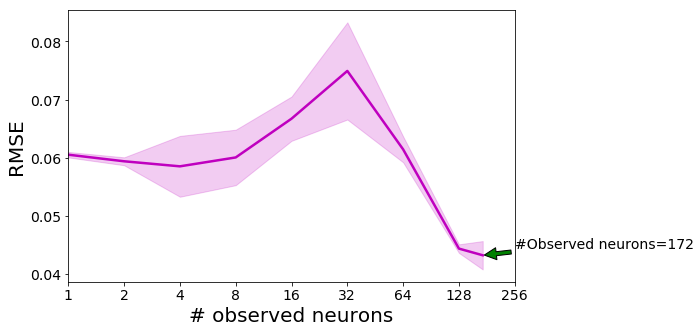

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [2**x for x in range(8)]
x.append(172)
xx = range(len(x))
y = np.median(np.median(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)

figName = '../partial_recordings/figures/NNMVI_RMSEs_Spiking_NZ'
fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .35, wspace=.15)
ax1.plot(x, y, linewidth=2.5, color='m')
plt.fill_between(x, y-error, y+error, alpha=0.2, color='m')

ax1.annotate('#Observed neurons=172', xy=(x[-1], y[-1]), xytext=(256, y[-2]),\
             fontsize=14, arrowprops=dict(facecolor='g', shrink=0.05))

ax1.set_xscale('log', basex=2)
ax1.set_xlabel('# observed neurons', fontsize=20)
ax1.set_xlim([1,2**8])
ax1.set_xticks([2**x for x in range(9)])
ax1.set_xticklabels( [2**x for x in range(9)], fontsize=14)
ax1.set_ylabel('RMSE', fontsize=20)
ylim = ax1.get_ylim()
ax1.set_ylim(ylim)
ax1.tick_params('both', labelsize=14)

plt.draw()
plt.savefig(figName +'.pdf', format='pdf')
plt.savefig(figName +'.eps', format='eps', dpi=1000)